# Predicting your geological sample using CNN

### - Goals
### - Workflow & Tools
### - Data Available

# Goals

### 1. Can Deep Learning be used for this?


### 2. Does it work?


### 3. How quick can we get some results?


## Modules used
![Modules_used](reveal.js/0.pics/modules_used.png)

## Workflow

![Deep Learning](reveal.js/0.pics/CNN_sketch_modified.png)

# Transfer Learning

In [1]:
import os
import cv2 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing

from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
from tensorflow.keras.preprocessing import image # Keras own inbuild image class

import warnings
warnings.filterwarnings("ignore")

2022-08-05 12:44:41.470799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ionel/anaconda3/envs/deep_learning/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-05 12:44:41.470871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Transfer Learning for Neural Networks

> Transfer learning consists of *taking features learned on one problem, and leveraging them on a new, similar problem. E.g. features from a model that has learned to identify fruits may be useful to kick-start a model meant to identify minerals.


1. Take the weights and architecture of a [pre-trained network](https://keras.io/api/applications/)
2. Load the "convolutional base" of the model (everything except the final dense layers)
3. Freeze all the layers of the base (weights become fixed)
4. Add a fully connected dense layer on top
5. **Add a task specific dense output layer**
6. Compile and fit the model to your data

## Load images into `keras`
Keras has its own in build Objects and Methods to get image data in efficiently

In [2]:
# folder names containing images of the things you want to classify
classes = ['amethyst', 'ammonite', 'aventurin', 'empty', 'obsidian']
# plug in the path to your data folder
base_path = './imageclassifier-main/data/original/'
base_path

'./imageclassifier-main/data/original/'

In [3]:
# ls

In [4]:
# define an image data generator
data_gen = preprocessing.image.ImageDataGenerator(
    # define the preprocessing function that should be applied to all images
    preprocessing_function=mobilenet_v2.preprocess_input,   
)

In [5]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory=base_path,
        class_mode="categorical",
        classes=classes,
        batch_size= 1000, # the total number of images to use for training in all classes
        target_size=(360, 375) # 224, 224
)

Found 1000 images belonging to 5 classes.


In [6]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((1000, 360, 375, 3), (1000, 5))

In [7]:
classes

['amethyst', 'ammonite', 'aventurin', 'empty', 'obsidian']

In [8]:
ytrain

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]], dtype=float32)

## Create CNN Model

### 1. Select the convolutional base 

In [9]:
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # !!!!! we only want to have the base, not the final dense layers 
    input_shape= (360, 375, 3) # 224, 224   360, 375  None
)

# import os
# os.environ['CUDA_VISIBLE_DEVICES'] ="0"
# CUDA_VISIBLE_DEVICES=0

2022-08-05 12:45:02.780573: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-05 12:45:02.780607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ionel-Latitude-5590): /proc/driver/nvidia/version does not exist
2022-08-05 12:45:02.781178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 2. Freeze the weights

In [10]:
# freeze it!
base_model.trainable = False

### 3. Add your own dense layers on top

In [11]:
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Dense(100, activation='relu')) #100
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 5, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 538,813
Trainable params: 128,605
Non-trainable params: 410,208
_________________________________________________________________


### 4. Compile and train!

## BE AWARE THAT FOR 1000 PICTURES IT CAN VERY TIME CONSUMING 
## (*SUBJECT TO  THE NUMBER OF EPOCHS USED 10- QUICK, 25-MEDIUM, 50-LONG)

In [112]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

# observe the validation loss and stop when it does not improve after 3 iterations
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(xtrain, ytrain, 
          epochs=50, # INTIALLY 50
          verbose=2,
          batch_size=25, #no of samples to be  used for the training
          callbacks=[callback],
          # use 30% of the data for validation
          validation_split=0.3)

Epoch 1/50


2022-08-05 14:02:18.547302: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1134000000 exceeds 10% of free system memory.


28/28 - 17s - loss: 0.0495 - categorical_accuracy: 0.9871 - val_loss: 0.0312 - val_categorical_accuracy: 0.9933 - 17s/epoch - 618ms/step
Epoch 2/50
28/28 - 15s - loss: 0.0231 - categorical_accuracy: 0.9971 - val_loss: 0.0421 - val_categorical_accuracy: 0.9833 - 15s/epoch - 533ms/step
Epoch 3/50
28/28 - 14s - loss: 0.0262 - categorical_accuracy: 0.9929 - val_loss: 0.0334 - val_categorical_accuracy: 0.9867 - 14s/epoch - 506ms/step
Epoch 4/50
28/28 - 14s - loss: 0.0187 - categorical_accuracy: 0.9957 - val_loss: 0.0264 - val_categorical_accuracy: 0.9933 - 14s/epoch - 501ms/step
Epoch 5/50
28/28 - 13s - loss: 0.0123 - categorical_accuracy: 1.0000 - val_loss: 0.0369 - val_categorical_accuracy: 0.9833 - 13s/epoch - 467ms/step
Epoch 6/50
28/28 - 13s - loss: 0.0208 - categorical_accuracy: 0.9929 - val_loss: 0.0170 - val_categorical_accuracy: 0.9933 - 13s/epoch - 463ms/step
Epoch 7/50
28/28 - 13s - loss: 0.0153 - categorical_accuracy: 0.9957 - val_loss: 0.0204 - val_categorical_accuracy: 0.9900 

### (5. Use it to predict)

In [9]:
img = image.load_img('test4.png')

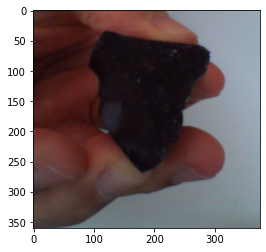

In [10]:
plt.imshow(img)

In [6]:
a = image.img_to_array(img)
a.shape

(360, 375, 3)

In [7]:
a = np.expand_dims(a, axis = 0)
a.shape

(1, 360, 375, 3)

In [8]:
model.predict(a)

NameError: name 'model' is not defined

In [243]:
model.predict(a)[0].round(decimals = 3)

1/1 [==============================] - 0s 34ms/step


array([0.001, 0.135, 0.041, 0.018, 0.805], dtype=float32)

In [244]:
classes

['amethyst', 'ammonite', 'aventurin', 'empty', 'obsidian']

1/1 [==============================] - 0s 33ms/step


<BarContainer object of 5 artists>

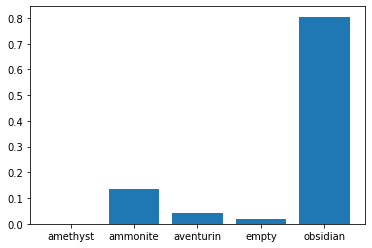

In [245]:
plt.bar(x = classes, height = model.predict(a)[0])

### (6. Save your model for later)

In [248]:
model.save('./imageclassifier-main/models/M3_rock_mineral_transfer.h5')